## Transition Dynamics for PBMA Aiyagari model

In this notebook, we discuss the transition dynamics from one equilibrium to the other equilibrium.

I use the methodology in Section 4 of [Transition Dynamics in the Aiyagari Model, with an application to Wealth Tax by Toshihiko Mukoyama](https://toshimukoyama.github.io/MyWebsite/Aiyagari.pdf) and apply it to the current setup.

Here I outline the algorithm as follows:

#### Step 1 Compute the Initial steady state and final steady state

We have already accomplished this computation. We obtained



*   $K_s$ as the steady-state capital for the short-run policy equilibrium (SRPE),

- the optimal short-run policy at the SRPE,  
- and its corresponding stationary asset distribution
*   $K_c$ as the steady-state capital for the continuation policy equilibrium (CPE),

- optimal continuation policy at the CPE,

- and its corresponding stationary asset distribution


#### Step 2 Guess the time series and Backward Induction

- Guess the time series $K_t$for $t=1,2,\cdots, T$, where $t=1$ is the period of unexpected change in discount factor

- $T$ is a sufficiently large future to ensure we arrive at another equilibrium after one unexpected change in discount factor

- Now we have a finite-horizon DP problem.

- We use backward induction to get the vaue functions and decision rules for $t=1,2,\cdots T$

#### Step 3 Forward simulation

- Use the decision rule above, simulate the economy forward

- calculate the simulated aggregate capital $K_t$ at $t=1,2,\cdots, T$

#### Step 4 Compare to the guess and iterate until convergence.

Now, we create the following function to do the above iteration.

In [1]:
!git clone https://github.com/longye-tian/my-phd

%run my-phd/QHD/PBMA_Ayagari.ipynb

Cloning into 'my-phd'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 360 (delta 44), reused 23 (delta 9), pack-reused 257 (from 1)
Receiving objects: 100% (360/360), 24.53 MiB | 13.89 MiB/s, done.
Resolving deltas: 100% (119/119), done.


We need a helper function to update the distribution.

In [2]:
# We modify out compute_asset_distribution a little bit to compute the joint distribution

@jax.jit
def compute_joint_stationary(σ, household):
    # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))
    σ = jnp.reshape(σ, (a_size, z_size, 1, 1))
    A = jnp.where(σ == ap_idx, 1, 0)
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))
    P_σ = A * Π

    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))

    # Get stationary distribution and reshape back onto [i, j] grid
    ψ = compute_stationary(P_σ)
    ψ = jnp.reshape(ψ, (a_size, z_size))

    return ψ

# We also build a helper function to update the joint distribution.

@jax.jit
def update_joint_stationary(ψ, σ, household):
    # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))
    σ = jnp.reshape(σ, (a_size, z_size, 1, 1))
    A = jnp.where(σ == ap_idx, 1, 0)
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))
    P_σ = A * Π

    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))

    # Reshape the input joint distribution into a vector
    ψ = jnp.reshape(ψ, (n, ))

    # Update the joint distribution
    ψ_new = jnp.dot(ψ, P_σ)

    # Reshape the updated joint distribution back to [i, j] grid
    ψ_new = jnp.reshape(ψ_new, (a_size, z_size))


    return ψ_new


In [3]:
# Compute transition dynamics from SRPE to CPE

def transit_SRPE_to_CPE(household,       # household parameters
                        firm,            # firm parameters
                        T=300,           # Max transition period
                        γ=0.9,           # damping parameter
                        max_iter=10000,  # maximum iteration
                        tol=1e-3,        # tolerance
                        verbose=True
                        ):
  # Step 1.1: Compute SRPE
  print("Computing initial steady state.....")

  K_init, _ = compute_equilibrium_short(firm, household)        # Compute SRPE capital as initial capital
  print(K_init)
  r_init = r_given_k(K_init, firm)                              # Compute SRPE interest rate as initial interest rate
  w_init = r_to_w(r_init, firm)                                 # Compute SRPE wage as initial wage
  price_init = create_prices(r=r_init, w=w_init)                 # Compute SRPE price as initial price

  σ_init, v_init = compute_lifetime(household, price_init)      # compute the SRPE optimal policy and value function

  # Step 1.2: Compute CPE
  print("Computing terminal steady state....")

  K_term, _ = compute_equilibrium_continuation(firm, household)     # Compute CPE capital as terminal capital
  print(K_term)
  r_term = r_given_k(K_term, firm)                                  # Compute CPE interest rate as terminal
  w_term = r_to_w(r_term, firm)                                     # Compute CPE wage as terminal
  price_term = create_prices(r=r_term, w=w_term)                     # Compute CPE price as terminal

  σ_term, v_term = howard_policy_iteration(household, price_term)   # compute the CPE optimal policy and value function


  # Step 1.3: Get initial stationary asset distribution
  print("Computing Initial stationary distribution......")

  ψ_init = compute_joint_stationary(σ_init, household)       # Compute initial stationary joint distribution

  # Step 2.1: Set up the Initial Guess
  K_path = np.linspace(K_init, K_term, T)                    # Set up the initial guess

  # Unpack the household parameters
  β, δ, a_grid, z_grid, Π = household
  a_size, z_size = len(a_grid), len(z_grid)

  # Initialize arrays to store policies and value functions for each time period
  σ_path = np.zeros((T, a_size, z_size))
  v_path = np.zeros((T, a_size, z_size))

  # Fill the initial and terminal as given
  σ_path[0] = σ_init
  v_path[0] = v_init
  σ_path[-1] = σ_term
  v_path[-1] = v_term


  # For tracking convergence
  iter_count = 0
  max_diff = tol + 1

  # Iteration Loop
  while max_diff > tol and iter_count < max_iter:
    # Compute interest rate and wages for the current capital path.
    r_path = np.array([r_given_k(K, firm) for K in K_path])
    w_path = np.array([r_to_w(r, firm) for r in r_path])

    # Step 2.2 Backward Induction
    # Start with final steady state value function
    v_next  = v_term

    # Backward induction
    for t in range(T-2, 0, -1):

      # Create prices for this period
      price_t = create_prices(r=r_path[t], w=w_path[t])

      # Solve a two-period DP problem under discount factor δ
      σ_t = get_greedy(v_next, household, price_t)    # v_next-greedy policy
      v_t = get_value(σ_t, household, price_t)        # σ_t-value function

      # Store policies and value functions
      σ_path[t] = σ_t
      v_path[t] = v_t

      # Update v_next for the next iteration
      v_next = v_t

    # Step 3: Forward Simulation
    # Start with initial stationary joint distribution
    ψ_t = ψ_init

    # Initialize the forward simulation path
    K_path_new = np.zeros(T)
    K_path_new[0] = K_init
    K_path_new[-1] = K_term

    # Forward Simution
    for t in range(1, T-1):

      # Update distribution using policy function for period t
      ψ_t = update_joint_stationary(ψ_t, σ_path[t], household)

      # Compute aggregate capital implied by current distribution
      K_path_new[t] = float(jnp.sum(jnp.sum(ψ_t, axis=1) * a_grid))

    # print(K_path_new)

    # Step 4: Check convergence and update capital path
    max_diff = np.max(np.abs(K_path_new - K_path))

    # Update capital path with damping
    K_path = γ * K_path + (1 - γ) * K_path_new

    # Update iteration count
    iter_count += 1

    if verbose and iter_count % 10 == 0:
      print(f"Iteration {iter_count}, max difference: {max_diff:.6f}")

  if max_diff <= tol:
    print(f"Convergence achieved after {iter_count} iterations.")
  else:
    print(f"Maximum iterations reached after {iter_count} without convergence.")


  # Compute transition path

  transition_path = {
      'K': K_path,
      'σ': σ_path,
      'v': v_path
  }

  return transition_path


#### Plot the transition dynamics

Here is the plot of the transition dynamics of capital $K$ from SRPE to CPE.

In [4]:

def plot_transition_SRPE_to_CPE(transition_path):
  # Extract the K values
  k_values = transition_path['K']

  # Create indices for the x-axis (0, 1, 2, ...)
  periods = np.arange(len(k_values))

  # Create the plot
  plt.figure(figsize=(10, 6))  # Set figure size
  plt.plot(periods, k_values, linewidth=2)  # Plot K values

  # Add labels and title
  plt.xlabel('Periods', fontsize=12)
  plt.ylabel('Aggregate Capital K', fontsize=12)
  plt.title('Transition Dynamics From SRPE to CPE', fontsize=14)

  # Add grid for better readability
  plt.grid(True, linestyle='--', alpha=0.7)

  # Optional: Customize the appearance
  plt.tight_layout()  # Adjust layout to make room for labels

  # Show the plot
  plt.show()

# Optional: Save the plot to a file
# plt.savefig('k_values_plot.png', dpi=300, bbox_inches='tight')

### From CPE to SRPE

In this section, we derive the transition dynamics from CPE to SRPE.

We slightly alter the above transition dynamic functions as follow:

In [30]:
# Compute transition dynamics from CPE to SRPE

def transit_CPE_to_SRPE(household,       # household parameters
                        firm,            # firm parameters
                        T=300,           # Max transition period
                        γ=0.98,           # damping parameter
                        max_iter=10000,  # maximum iteration
                        tol=1e-3,        # tolerance
                        verbose=True
                        ):
  # Step 1.1: Compute CPE
  print("Computing initial steady state.....")

  K_init, _ = compute_equilibrium_continuation(firm, household)        # Compute CPE capital as initial capital
  print(K_init)
  r_init = r_given_k(K_init, firm)                              # Compute CPE interest rate as initial interest rate
  w_init = r_to_w(r_init, firm)                                 # Compute CPE wage as initial wage
  price_init = create_prices(r=r_init, w=w_init)                 # Compute CPE price as initial price

  σ_init, v_init = howard_policy_iteration(household, price_init)      # compute the CPE optimal policy and value function

  # Step 1.2: Compute SRPE
  print("Computing terminal steady state....")

  K_term, _ = compute_equilibrium_short(firm, household)     # Compute SRPE capital as terminal capital
  print(K_term)
  r_term = r_given_k(K_term, firm)                                  # Compute SRPE interest rate as terminal
  w_term = r_to_w(r_term, firm)                                     # Compute SRPE wage as terminal
  price_term = create_prices(r=r_term, w=w_term)                     # Compute SRPE price as terminal

  σ_term, v_term = compute_lifetime(household, price_term)   # compute the SRPE optimal policy and value function


  # Step 1.3: Get initial stationary asset distribution
  print("Computing Initial stationary distribution......")

  ψ_init = compute_joint_stationary(σ_init, household)       # Compute initial stationary joint distribution

  # Step 2.1: Set up the Initial Guess
  # K_path = np.linspace(K_init, K_term, T)                    # Set up the initial guess

  # Replace linear interpolation
  K_path = np.linspace(K_init, K_term, T)

  # With exponential decay
  #decay_rate = -np.log(K_term/K_init) / (T/3)
  # K_path = K_init * np.exp(-decay_rate * np.arange(T))
  # K_path[-1] = K_term  # Force terminal value

  # Unpack the household parameters
  β, δ, a_grid, z_grid, Π = household
  a_size, z_size = len(a_grid), len(z_grid)

  # Initialize arrays to store policies and value functions for each time period
  σ_path = np.zeros((T, a_size, z_size))
  v_path = np.zeros((T, a_size, z_size))

  # Fill the initial and terminal as given
  σ_path[0] = σ_init
  v_path[0] = v_init
  σ_path[-1] = σ_term
  v_path[-1] = v_term


  # For tracking convergence
  iter_count = 0
  max_diff = tol + 1

  # Iteration Loop
  while max_diff > tol and iter_count < max_iter:
    # Compute interest rate and wages for the current capital path.
    r_path = np.array([r_given_k(K, firm) for K in K_path])
    w_path = np.array([r_to_w(r, firm) for r in r_path])

    # Step 2.2 Backward Induction
    # Start with final steady state value function
    v_next  = v_term

    # Backward induction
    for t in range(T-2, 0, -1):

      # Create prices for this period
      price_t = create_prices(r=r_path[t], w=w_path[t])

      # Solve a two-period DP problem under discount factor β * δ
      σ_t = get_greedy_0(v_next, household, price_t)    # v_next-greedy policy
      v_t = get_value_0(σ_t, household, price_t)        # σ_t-value function

      # Store policies and value functions
      σ_path[t] = σ_t
      v_path[t] = v_t

      # Update v_next for the next iteration
      v_next = v_t

    # Step 3: Forward Simulation
    # Start with initial stationary joint distribution
    ψ_t = ψ_init

    # Initialize the forward simulation path
    K_path_new = np.zeros(T)
    K_path_new[0] = K_init
    K_path_new[-1] = K_term

    # Forward Simution
    for t in range(1, T-1):

      # Update distribution using policy function for period t
      ψ_t = update_joint_stationary(ψ_t, σ_path[t], household)

      # Compute aggregate capital implied by current distribution
      K_path_new[t] = float(jnp.sum(jnp.sum(ψ_t, axis=1) * a_grid))

    # print(K_path_new)

    # Step 4: Check convergence and update capital path
    max_diff = np.max(np.abs(K_path_new - K_path))

    # Update capital path with damping
    K_path = γ * K_path + (1 - γ) * K_path_new

    # Update iteration count
    iter_count += 1

    if verbose and iter_count % 10 == 0:
      print(f"Iteration {iter_count}, max difference: {max_diff:.6f}")

  if max_diff <= tol:
    print(f"Convergence achieved after {iter_count} iterations.")
  else:
    print(f"Maximum iterations reached after {iter_count} without convergence.")


  # Compute transition path

  transition_path = {
      'K': K_path,
      'σ': σ_path,
      'v': v_path
  }

  return transition_path

Here is the corresponding function to plot the transition from CPE to SRPE.

In [6]:

def plot_transition_CPE_to_SRPE(transition_path):
  # Extract the K values
  k_values = transition_path['K']

  # Create indices for the x-axis (0, 1, 2, ...)
  periods = np.arange(len(k_values))

  # Create the plot
  plt.figure(figsize=(10, 6))  # Set figure size
  plt.plot(periods, k_values, linewidth=2)  # Plot K values

  # Add labels and title
  plt.xlabel('Periods', fontsize=12)
  plt.ylabel('Aggregate Capital K', fontsize=12)
  plt.title('Transition Dynamics From CPE to SRPE', fontsize=14)

  # Add grid for better readability
  plt.grid(True, linestyle='--', alpha=0.7)

  # Optional: Customize the appearance
  plt.tight_layout()  # Adjust layout to make room for labels

  # Show the plot
  plt.show()

# Optional: Save the plot to a file
# plt.savefig('k_values_plot.png', dpi=300, bbox_inches='tight')

Now we plot these transition dynamics. β



In [11]:
# firm = create_firm()
# household = create_household(β=0.8)
# transition_path_SRPE_to_CPE = transit_SRPE_to_CPE(household, firm)

Computing initial steady state.....
6.548295652758456
Computing terminal steady state....
8.09182514667204
Computing Initial stationary distribution......
Iteration 10, max difference: 0.343306
Iteration 20, max difference: 0.057197
Iteration 30, max difference: 0.013034
Iteration 40, max difference: 0.003800
Iteration 50, max difference: 0.003685
Iteration 60, max difference: 0.002137
Iteration 70, max difference: 0.003099
Convergence achieved after 72 iterations.


In [ ]:
# firm = create_firm()
# household = create_household(β=0.5)
# transition_path_CPE_to_SRPE = transit_CPE_to_SRPE(household, firm)

Computing initial steady state.....
8.09182514667204
Computing terminal steady state....


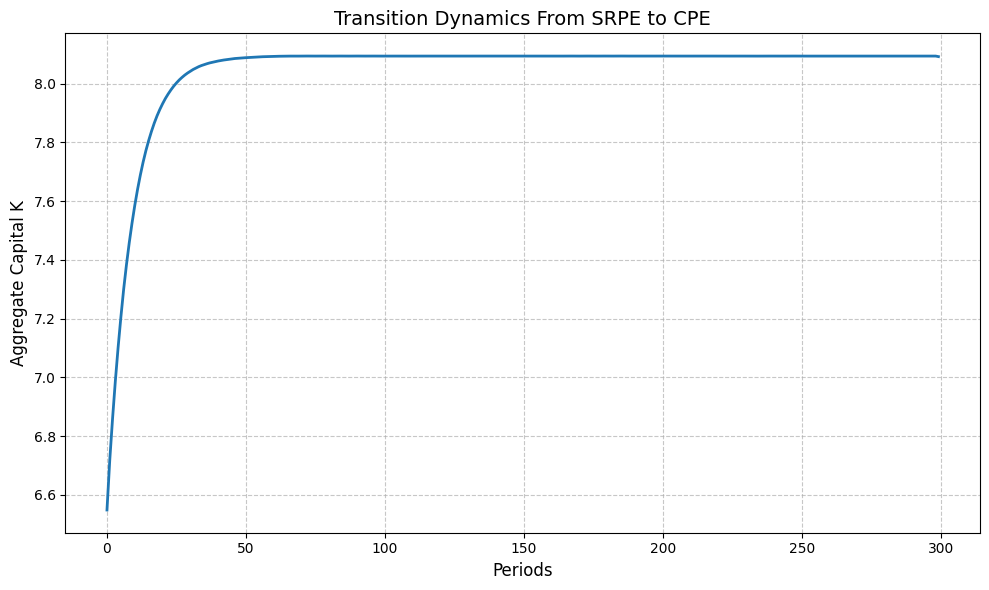

In [21]:
# plot_transition_SRPE_to_CPE(transition_path_SRPE_to_CPE)

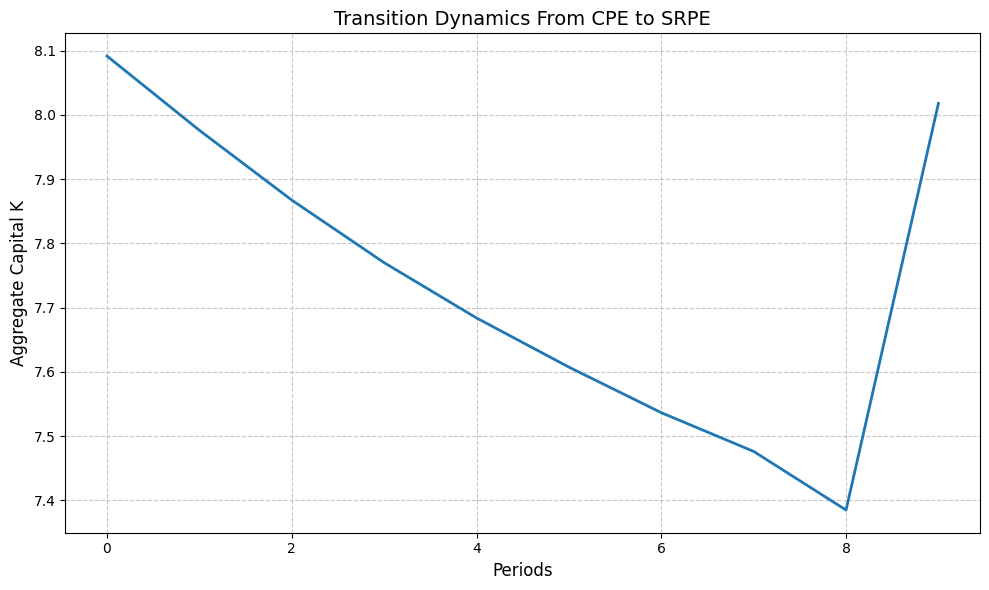

In [26]:
# plot_transition_CPE_to_SRPE(transition_path_CPE_to_SRPE)